# Initializing project

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import time

#for google access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = "../content/drive/My Drive/CSCI_534 Project/Project/Gamestop Data"
# project_path = './'

gm_stock = pd.read_csv(project_path+'/Gamestop Stock Data.csv') #181 of sample
gm_liwc = pd.read_csv(project_path+'/gamestop_investor_liwc.csv') 
gm_liwc.shape#2236

(2236, 95)

In [6]:
gm_liwc = gm_liwc.dropna(subset=['Datetime','Text','drives','affiliation','achieve','power','reward','risk'])
gm_liwc.shape #2213

(2213, 95)

# Preparing data

In this part, we will combine and prepare the data is neccessary for the model to learn such as date, stock price and liwc scores.

In [7]:
#In this part we are preparing data for processing (taking datetime and scores from liwc data)
gm_liwc_date = gm_liwc['Datetime'].to_numpy()
gm_liwc_drives = gm_liwc['drives'].to_numpy()
gm_liwc_affiliation = gm_liwc['affiliation'].to_numpy()
gm_liwc_achieve = gm_liwc['achieve'].to_numpy()
gm_liwc_power = gm_liwc['power'].to_numpy()
gm_liwc_reward = gm_liwc['reward'].to_numpy()
gm_liwc_risk = gm_liwc['risk'].to_numpy()

In [8]:
gm_liwc_date

array(['2021/2/3 0:00', '2021/1/22 0:00', '2021/2/1 0:00', ...,
       '2021/1/29 0:00', '2021/1/29 0:00', '2021/1/29 0:00'], dtype=object)

In [9]:
#Cleaning gm data
for i in range(len(gm_liwc_date)):
    gm_liwc_date[i] = gm_liwc_date[i].split()[0] #cleaning the data only the date
    #change date fromat
    #mm/dd/yyy
    gm_liwc_date[i]=time.strptime(gm_liwc_date[i],'%Y/%m/%d') 
    gm_liwc_date[i]=time.strftime('%m/%d/%Y',gm_liwc_date[i]) 

In [10]:
#put gm liwc data in df
gm_liwc_df = pd.DataFrame({
    'Date':gm_liwc_date,
    'drives':gm_liwc_drives,
    'affiliation':gm_liwc_affiliation,
    'achieve':gm_liwc_achieve,
    'power':gm_liwc_power,
    'reward':gm_liwc_reward,
    'risk':gm_liwc_risk
})
#combine data on the same date(caculate the descriptive statistics of "drives","affiliation","achieve","power","reward","risk")
#mean
gm_liwc_df_mean = gm_liwc_df.groupby(['Date']).agg({'drives':np.mean,'affiliation':np.mean,'achieve':np.mean,'power':np.mean,'reward':np.mean,'risk':np.mean}).reset_index()
#median
gm_liwc_df_median = gm_liwc_df.groupby(['Date']).agg({'drives':np.median,'affiliation':np.median,'achieve':np.median,'power':np.median,'reward':np.median,'risk':np.median}).reset_index()
#std
gm_liwc_df_std = gm_liwc_df.groupby(['Date']).agg({'drives':np.std,'affiliation':np.std,'achieve':np.std,'power':np.std,'reward':np.std,'risk':np.std}).reset_index()
#max
gm_liwc_df_max = gm_liwc_df.groupby(['Date']).agg({'drives':np.max,'affiliation':np.max,'achieve':np.max,'power':np.max,'reward':np.max,'risk':np.max}).reset_index()
#min
gm_liwc_df_min = gm_liwc_df.groupby(['Date']).agg({'drives':np.min,'affiliation':np.min,'achieve':np.min,'power':np.min,'reward':np.min,'risk':np.min}).reset_index()

In [11]:
#clean the stock date(taking datetime and close from stock data)
gm_stock_date = gm_stock['Date'].to_numpy()
gm_stock_close = gm_stock['Close'].to_numpy()

In [12]:
#get stock date and change format
for i in range(len(gm_stock_date)):
  gm_stock_date[i] = gm_stock_date[i].split()[0]
  gm_stock_date[i]=time.strptime(gm_stock_date[i],'%m/%d/%Y')
  gm_stock_date[i]=time.strftime('%m/%d/%Y',gm_stock_date[i])

In [13]:
#put gm stock data in df
gm_stock_df = pd.DataFrame({
    'Date':gm_stock_date,
    'close':gm_stock_close
})
#gm_stock_df

In [14]:
#normalizing the stock value
gm_stock_df['close'] = (gm_stock_df['close'] - gm_stock_df['close'].min()) / (gm_stock_df['close'].max() - gm_stock_df['close'].min())
#gm_stock_df

In [16]:
#merge liwc mean data and stock data
gm_merge_df_mean = pd.merge(gm_liwc_df_mean,gm_stock_df,on='Date',how="left")
gm_merge_df_mean = gm_merge_df_mean.dropna().reset_index(drop=True)

#median
gm_merge_df_median = pd.merge(gm_liwc_df_median,gm_stock_df,on='Date',how="left")
gm_merge_df_median = gm_merge_df_median.dropna().reset_index(drop=True)

#std
gm_merge_df_std = pd.merge(gm_liwc_df_std,gm_stock_df,on='Date',how="left")
gm_merge_df_std = gm_merge_df_std.dropna().reset_index(drop=True)

#max
gm_merge_df_max = pd.merge(gm_liwc_df_max,gm_stock_df,on='Date',how="left")
gm_merge_df_max = gm_merge_df_max.dropna().reset_index(drop=True)

#min
gm_merge_df_min = pd.merge(gm_liwc_df_min,gm_stock_df,on='Date',how="left")
gm_merge_df_min = gm_merge_df_min.dropna().reset_index(drop=True)

gm_merge_df_mean.shape #42 days worth of data

(42, 8)

# Training the linear model

Training the linear model for Gamestop

In [17]:
#Creating a model based on the gm data
#gm_merge_df[['drives','affiliation','achieve','power','reward','risk']] is the data or x or feature
#gm_merge_df[['close']] is the label
#mean
reg_gm_mean = LinearRegression().fit(gm_merge_df_mean[['drives','affiliation','achieve','power','reward','risk']][:-10], gm_merge_df_mean[['close']][:-10])
#median
reg_gm_median = LinearRegression().fit(gm_merge_df_median[['drives','affiliation','achieve','power','reward','risk']][:-10], gm_merge_df_median[['close']][:-10])
#std
reg_gm_std = LinearRegression().fit(gm_merge_df_std[['drives','affiliation','achieve','power','reward','risk']][:-10], gm_merge_df_std[['close']][:-10])
#max
reg_gm_max = LinearRegression().fit(gm_merge_df_max[['drives','affiliation','achieve','power','reward','risk']][:-10], gm_merge_df_max[['close']][:-10])
#min
reg_gm_min = LinearRegression().fit(gm_merge_df_min[['drives','affiliation','achieve','power','reward','risk']][:-10], gm_merge_df_min[['close']][:-10])

# Plot the data and model of for each company

Predict Gamestop model with all feature

In [18]:
#each model is predicting the label using the data that we have
#pred_gm is a numpy array consisting the values of prediction of the gm data that we use for the training
#mean 
pred_gm_mean = reg_gm_mean.predict(gm_merge_df_mean[['drives','affiliation','achieve','power','reward','risk']][-10:])
#median
pred_gm_median = reg_gm_median.predict(gm_merge_df_median[['drives','affiliation','achieve','power','reward','risk']][-10:])
#std
pred_gm_std = reg_gm_std.predict(gm_merge_df_std[['drives','affiliation','achieve','power','reward','risk']][-10:])
#max
pred_gm_max = reg_gm_max.predict(gm_merge_df_max[['drives','affiliation','achieve','power','reward','risk']][-10:])
#min
pred_gm_min = reg_gm_min.predict(gm_merge_df_min[['drives','affiliation','achieve','power','reward','risk']][-10:])

#To plot the training model
#mean 
train_gm_mean = reg_gm_mean.predict(gm_merge_df_mean[['drives','affiliation','achieve','power','reward','risk']][:-10])
#median
train_gm_median = reg_gm_median.predict(gm_merge_df_median[['drives','affiliation','achieve','power','reward','risk']][:-10])
#std
train_gm_std = reg_gm_std.predict(gm_merge_df_std[['drives','affiliation','achieve','power','reward','risk']][:-10])
#max
train_gm_max = reg_gm_max.predict(gm_merge_df_max[['drives','affiliation','achieve','power','reward','risk']][:-10])
#min
train_gm_min = reg_gm_min.predict(gm_merge_df_min[['drives','affiliation','achieve','power','reward','risk']][:-10])

#In this part, I am combining the data of each company with the prediction
#mean
gm_merge_pred_mean = pd.concat([gm_merge_df_mean[:-10], pd.DataFrame(train_gm_mean,columns=['pred'])], axis=1)
#median
gm_merge_pred_median = pd.concat([gm_merge_df_median[:-10], pd.DataFrame(train_gm_median,columns=['pred'])], axis=1)
#std
gm_merge_pred_std = pd.concat([gm_merge_df_std[:-10], pd.DataFrame(train_gm_std,columns=['pred'])], axis=1)
#max
gm_merge_pred_max = pd.concat([gm_merge_df_max[:-10], pd.DataFrame(train_gm_max,columns=['pred'])], axis=1)
#min
gm_merge_pred_min = pd.concat([gm_merge_df_min[:-10], pd.DataFrame(train_gm_min,columns=['pred'])], axis=1)

Display the perfomance of the model

In [19]:
from sklearn.metrics import mean_squared_error

#This is the score of the prediction/ performance of the model
#mean
gm_score_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_mean)
#median
gm_score_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_median)
#std
gm_score_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_std)
#max
gm_score_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_max)
#min
gm_score_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_min)
[gm_score_mean,gm_score_median,gm_score_std,gm_score_max,gm_score_min]

[0.19531324183920637,
 0.07242397849914058,
 1.275502061324397,
 0.005965697102547745,
 0.02000838714953685]

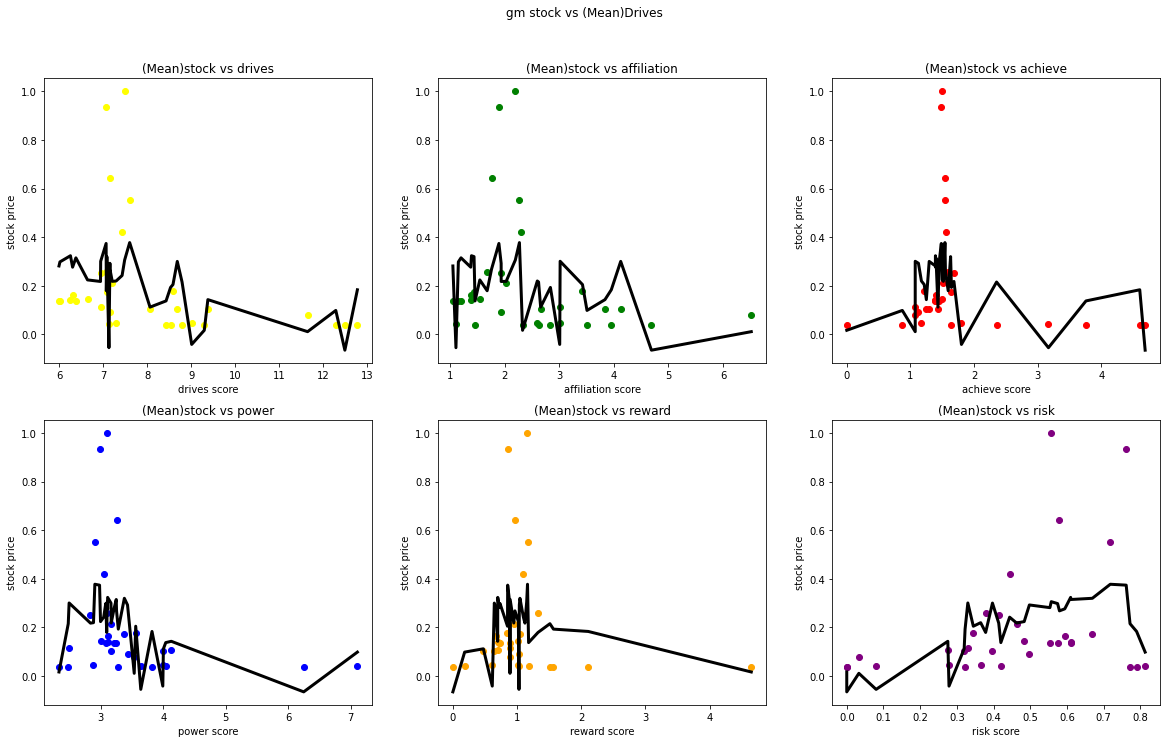

In [20]:
#plot gm 'drives','affiliation','achieve','power','reward','risk'
#In this part, it is plotting the data with the stock + the model itself
#Mean Drives
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Mean)Drives')
fig.set_size_inches(20,10)

gm_sort_drives_mean = gm_merge_pred_mean.sort_values(by=['drives'])
axs[0,0].scatter(gm_sort_drives_mean[['drives']],gm_sort_drives_mean[['close']],color='yellow',label='drives')#Plotting the data
axs[0,0].plot(gm_sort_drives_mean[['drives']], gm_sort_drives_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,0].set_title('(Mean)stock vs drives')
axs[0,0].set(xlabel='drives score', ylabel='stock price')

gm_sort_affiliation_mean = gm_merge_pred_mean.sort_values(by=['affiliation'])
axs[0,1].scatter(gm_sort_affiliation_mean[['affiliation']],gm_sort_affiliation_mean[['close']],color='green',label='affiliation')#Plotting the data
axs[0,1].plot(gm_sort_affiliation_mean[['affiliation']], gm_sort_affiliation_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(Mean)stock vs affiliation')
axs[0,1].set(xlabel='affiliation score', ylabel='stock price')

gm_sort_achieve_mean = gm_merge_pred_mean.sort_values(by=['achieve'])
axs[0,2].scatter(gm_sort_achieve_mean[['achieve']],gm_sort_achieve_mean[['close']],color='red',label='achieve') #Plotting the data
axs[0,2].plot(gm_sort_achieve_mean[['achieve']], gm_sort_achieve_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,2].set_title('(Mean)stock vs achieve')
axs[0,2].set(xlabel='achieve score', ylabel='stock price')

gm_sort_power_mean = gm_merge_pred_mean.sort_values(by=['power'])
axs[1,0].scatter(gm_sort_power_mean[['power']],gm_sort_power_mean[['close']],color='blue',label='power') #Plotting the data
axs[1,0].plot(gm_sort_power_mean[['power']], gm_sort_power_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,0].set_title('(Mean)stock vs power')
axs[1,0].set(xlabel='power score', ylabel='stock price')

gm_sort_reward_mean = gm_merge_pred_mean.sort_values(by=['reward'])
axs[1,1].scatter(gm_sort_reward_mean[['reward']],gm_sort_reward_mean[['close']],color='orange',label='reward') #Plotting the data
axs[1,1].plot(gm_sort_reward_mean[['reward']], gm_sort_reward_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,1].set_title('(Mean)stock vs reward')
axs[1,1].set(xlabel='reward score', ylabel='stock price')

gm_sort_risk_mean = gm_merge_pred_mean.sort_values(by=['risk'])
axs[1,2].scatter(gm_sort_risk_mean[['risk']],gm_sort_risk_mean[['close']],color='purple',label='risk') #Plotting the data
axs[1,2].plot(gm_sort_risk_mean[['risk']], gm_sort_risk_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,2].set_title('(Mean)stock vs risk')
axs[1,2].set(xlabel='risk score', ylabel='stock price')

plt.show()

In [ ]:
#Median Drives

In [ ]:
#Std Drives

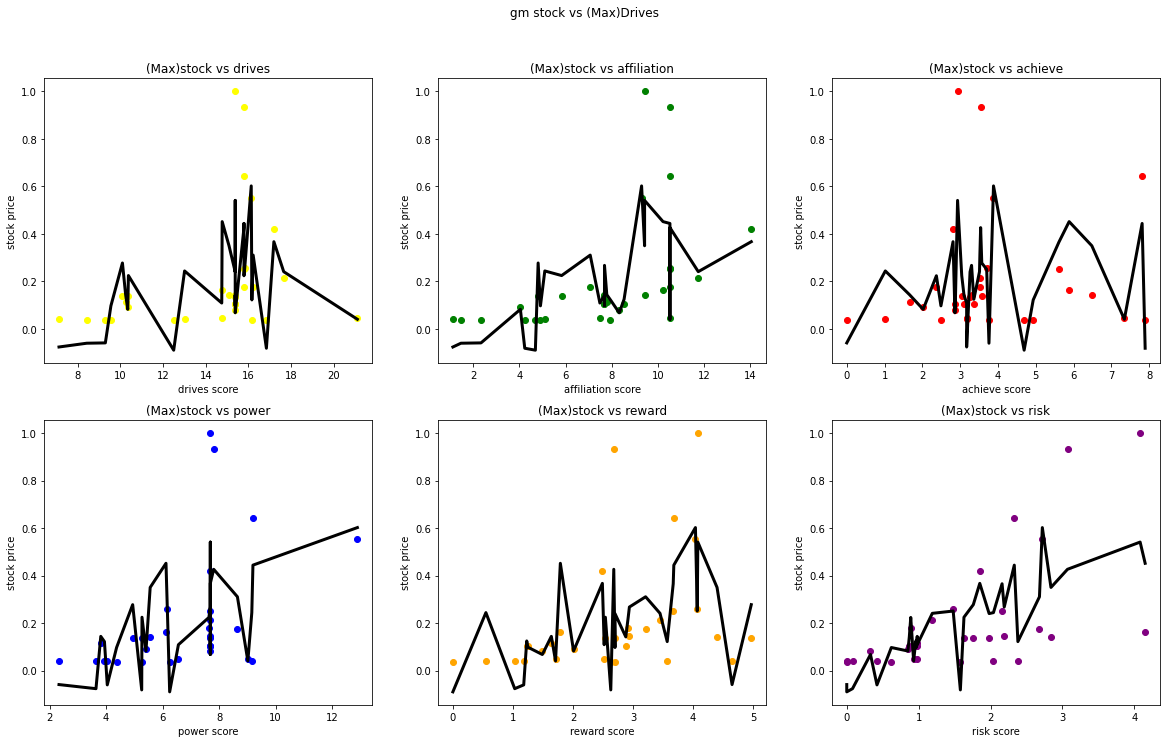

In [21]:
#Max Drives
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Max)Drives')
fig.set_size_inches(20,10)

gm_sort_drives_max = gm_merge_pred_max.sort_values(by=['drives'])
axs[0,0].scatter(gm_sort_drives_max[['drives']],gm_sort_drives_max[['close']],color='yellow',label='drives')#Plotting the data
axs[0,0].plot(gm_sort_drives_max[['drives']], gm_sort_drives_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,0].set_title('(Max)stock vs drives')
axs[0,0].set(xlabel='drives score', ylabel='stock price')

gm_sort_affiliation_max = gm_merge_pred_max.sort_values(by=['affiliation'])
axs[0,1].scatter(gm_sort_affiliation_max[['affiliation']],gm_sort_affiliation_max[['close']],color='green',label='affiliation')#Plotting the data
axs[0,1].plot(gm_sort_affiliation_max[['affiliation']], gm_sort_affiliation_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(Max)stock vs affiliation')
axs[0,1].set(xlabel='affiliation score', ylabel='stock price')

gm_sort_achieve_max = gm_merge_pred_max.sort_values(by=['achieve'])
axs[0,2].scatter(gm_sort_achieve_max[['achieve']],gm_sort_achieve_max[['close']],color='red',label='achieve') #Plotting the data
axs[0,2].plot(gm_sort_achieve_max[['achieve']], gm_sort_achieve_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,2].set_title('(Max)stock vs achieve')
axs[0,2].set(xlabel='achieve score', ylabel='stock price')

gm_sort_power_max = gm_merge_pred_max.sort_values(by=['power'])
axs[1,0].scatter(gm_sort_power_max[['power']],gm_sort_power_max[['close']],color='blue',label='power') #Plotting the data
axs[1,0].plot(gm_sort_power_max[['power']], gm_sort_power_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,0].set_title('(Max)stock vs power')
axs[1,0].set(xlabel='power score', ylabel='stock price')

gm_sort_reward_max = gm_merge_pred_max.sort_values(by=['reward'])
axs[1,1].scatter(gm_sort_reward_max[['reward']],gm_sort_reward_max[['close']],color='orange',label='reward') #Plotting the data
axs[1,1].plot(gm_sort_reward_max[['reward']], gm_sort_reward_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,1].set_title('(Max)stock vs reward')
axs[1,1].set(xlabel='reward score', ylabel='stock price')

gm_sort_risk_max = gm_merge_pred_max.sort_values(by=['risk'])
axs[1,2].scatter(gm_sort_risk_max[['risk']],gm_sort_risk_max[['close']],color='purple',label='risk') #Plotting the data
axs[1,2].plot(gm_sort_risk_max[['risk']], gm_sort_risk_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[1,2].set_title('(Max)stock vs risk')
axs[1,2].set(xlabel='risk score', ylabel='stock price')

plt.show()

In [ ]:
#Min Drives

# Plot data against time

Plotting gamestop stock with mean Drives

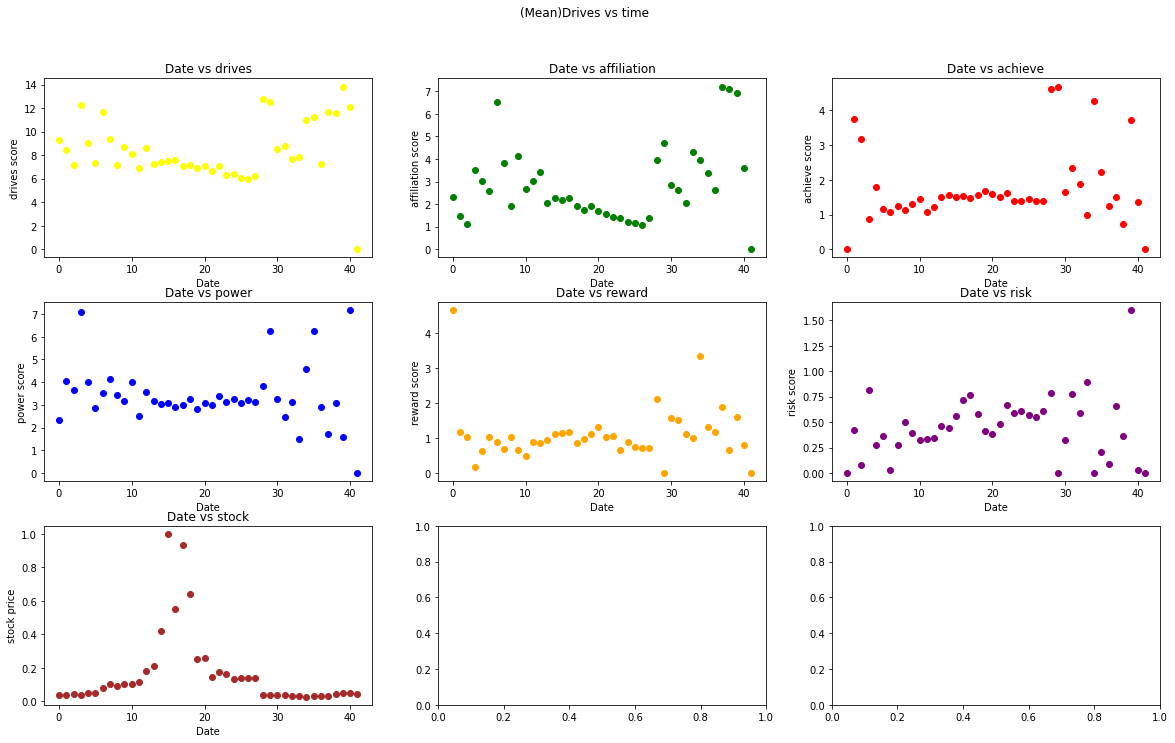

In [22]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(bottom=0.01,hspace=0.25)
fig.suptitle('(Mean)Drives vs time')
fig.set_size_inches(20,10)

gm_sort_drives_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_drives_mean.shape[0])],gm_sort_drives_mean[['drives']],color='yellow',label='drives')
axs[0,0].set_title('Date vs drives')
axs[0,0].set(xlabel='Date', ylabel='drives score')

gm_sort_affiliation_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_affiliation_mean.shape[0])],gm_sort_affiliation_mean[['affiliation']],color='green',label='affiliation')
axs[0,1].set_title('Date vs affiliation')
axs[0,1].set(xlabel='Date', ylabel='affiliation score')

gm_sort_achieve_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_achieve_mean.shape[0])],gm_sort_achieve_mean[['achieve']],color='red',label='achieve')
axs[0,2].set_title('Date vs achieve')
axs[0,2].set(xlabel='Date', ylabel='achieve score')

gm_sort_power_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_power_mean.shape[0])],gm_sort_power_mean[['power']],color='blue',label='power')
axs[1,0].set_title('Date vs power')
axs[1,0].set(xlabel='Date', ylabel='power score')

gm_sort_reward_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_reward_mean.shape[0])],gm_sort_reward_mean[['reward']],color='orange',label='reward')
axs[1,1].set_title('Date vs reward')
axs[1,1].set(xlabel='Date', ylabel='reward score')

gm_sort_risk_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[1,2].scatter([i for i in range(gm_sort_risk_mean.shape[0])],gm_sort_risk_mean[['risk']],color='purple',label='risk')
axs[1,2].set_title('Date vs risk')
axs[1,2].set(xlabel='Date', ylabel='risk score')

gm_sort_date = gm_merge_df_mean.sort_values(by=['Date'])
axs[2,0].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[2,0].set_title('Date vs stock')
axs[2,0].set(xlabel='Date', ylabel='stock price')

plt.show()

Plotting gamestop stock with median Drives

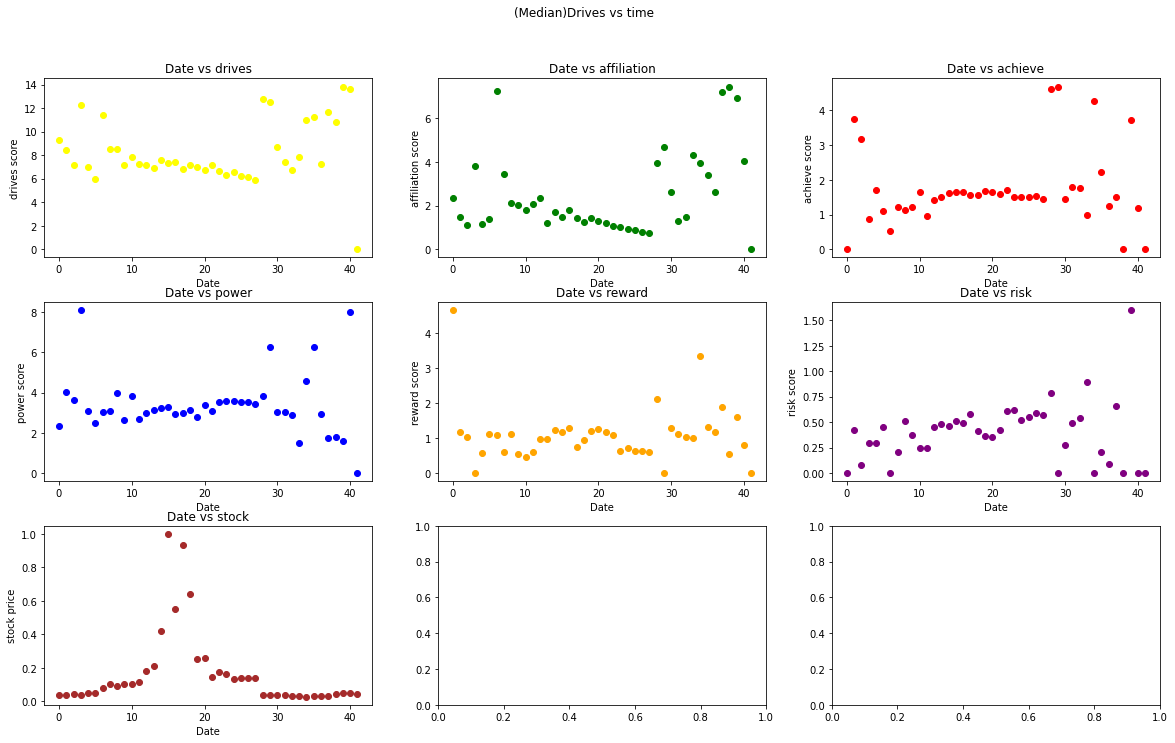

In [23]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(bottom=0.01,hspace=0.25)
fig.suptitle('(Median)Drives vs time')
fig.set_size_inches(20,10)

gm_sort_drives_median = gm_merge_df_median.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_drives_median.shape[0])],gm_sort_drives_median[['drives']],color='yellow',label='drives')
axs[0,0].set_title('Date vs drives')
axs[0,0].set(xlabel='Date', ylabel='drives score')

gm_sort_affiliation_median = gm_merge_df_median.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_affiliation_median.shape[0])],gm_sort_affiliation_median[['affiliation']],color='green',label='affiliation')
axs[0,1].set_title('Date vs affiliation')
axs[0,1].set(xlabel='Date', ylabel='affiliation score')

gm_sort_achieve_median = gm_merge_df_median.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_achieve_median.shape[0])],gm_sort_achieve_median[['achieve']],color='red',label='achieve')
axs[0,2].set_title('Date vs achieve')
axs[0,2].set(xlabel='Date', ylabel='achieve score')

gm_sort_power_median = gm_merge_df_median.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_power_median.shape[0])],gm_sort_power_median[['power']],color='blue',label='power')
axs[1,0].set_title('Date vs power')
axs[1,0].set(xlabel='Date', ylabel='power score')

gm_sort_reward_median = gm_merge_df_median.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_reward_median.shape[0])],gm_sort_reward_median[['reward']],color='orange',label='reward')
axs[1,1].set_title('Date vs reward')
axs[1,1].set(xlabel='Date', ylabel='reward score')

gm_sort_risk_median = gm_merge_df_median.sort_values(by=['Date'])
axs[1,2].scatter([i for i in range(gm_sort_risk_median.shape[0])],gm_sort_risk_median[['risk']],color='purple',label='risk')
axs[1,2].set_title('Date vs risk')
axs[1,2].set(xlabel='Date', ylabel='risk score')

gm_sort_date = gm_merge_df_median.sort_values(by=['Date'])
axs[2,0].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[2,0].set_title('Date vs stock')
axs[2,0].set(xlabel='Date', ylabel='stock price')

plt.show()

Plotting gamestop stock with std Drives

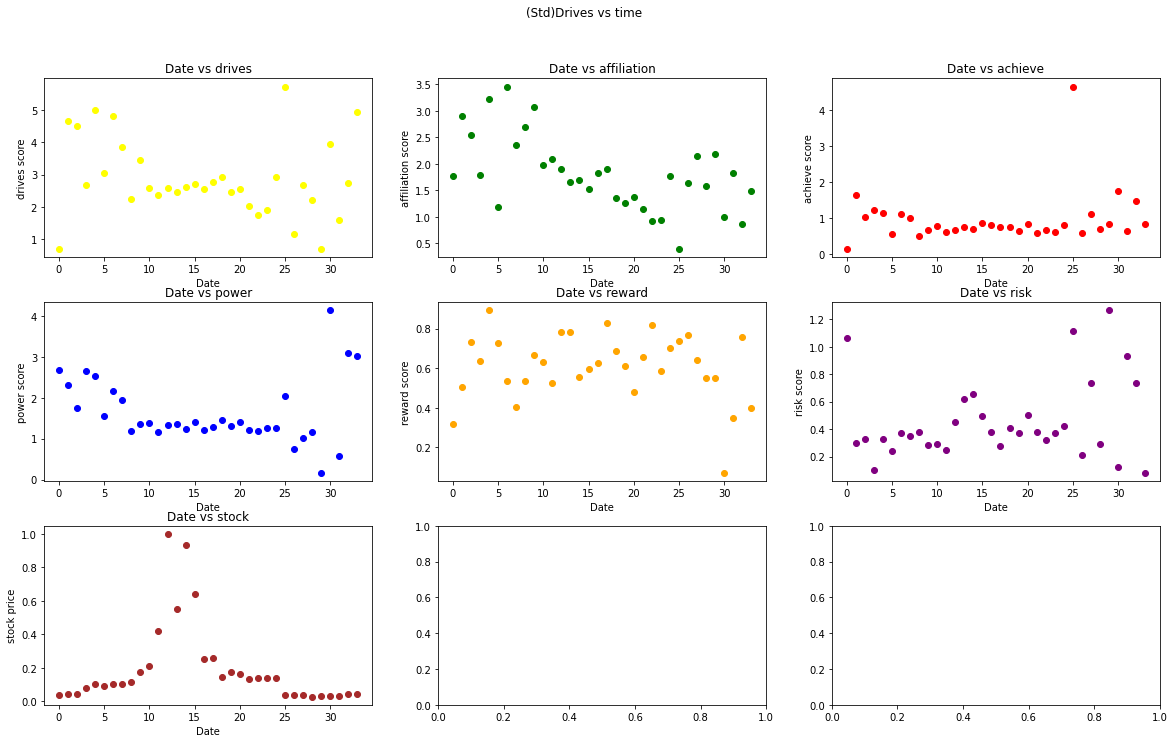

In [24]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(bottom=0.01,hspace=0.25)
fig.suptitle('(Std)Drives vs time')
fig.set_size_inches(20,10)

gm_sort_drives_std = gm_merge_df_std.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_drives_std.shape[0])],gm_sort_drives_std[['drives']],color='yellow',label='drives')
axs[0,0].set_title('Date vs drives')
axs[0,0].set(xlabel='Date', ylabel='drives score')

gm_sort_affiliation_std = gm_merge_df_std.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_affiliation_std.shape[0])],gm_sort_affiliation_std[['affiliation']],color='green',label='affiliation')
axs[0,1].set_title('Date vs affiliation')
axs[0,1].set(xlabel='Date', ylabel='affiliation score')

gm_sort_achieve_std = gm_merge_df_std.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_achieve_std.shape[0])],gm_sort_achieve_std[['achieve']],color='red',label='achieve')
axs[0,2].set_title('Date vs achieve')
axs[0,2].set(xlabel='Date', ylabel='achieve score')

gm_sort_power_std = gm_merge_df_std.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_power_std.shape[0])],gm_sort_power_std[['power']],color='blue',label='power')
axs[1,0].set_title('Date vs power')
axs[1,0].set(xlabel='Date', ylabel='power score')

gm_sort_reward_std = gm_merge_df_std.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_reward_std.shape[0])],gm_sort_reward_std[['reward']],color='orange',label='reward')
axs[1,1].set_title('Date vs reward')
axs[1,1].set(xlabel='Date', ylabel='reward score')

gm_sort_risk_std = gm_merge_df_std.sort_values(by=['Date'])
axs[1,2].scatter([i for i in range(gm_sort_risk_std.shape[0])],gm_sort_risk_std[['risk']],color='purple',label='risk')
axs[1,2].set_title('Date vs risk')
axs[1,2].set(xlabel='Date', ylabel='risk score')

gm_sort_date = gm_merge_df_std.sort_values(by=['Date'])
axs[2,0].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[2,0].set_title('Date vs stock')
axs[2,0].set(xlabel='Date', ylabel='stock price')

plt.show()

Plotting gamestop stock with maximum Drives

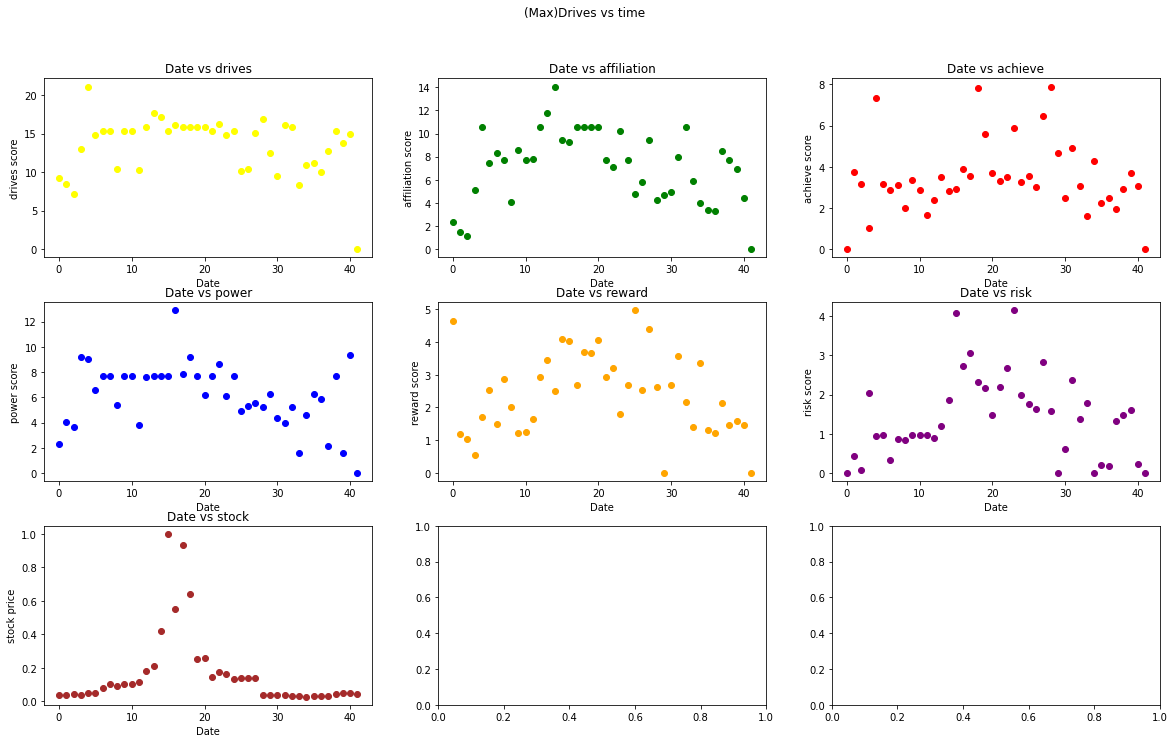

In [25]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(bottom=0.01,hspace=0.25)
fig.suptitle('(Max)Drives vs time')
fig.set_size_inches(20,10)

gm_sort_drives_max = gm_merge_df_max.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_drives_max.shape[0])],gm_sort_drives_max[['drives']],color='yellow',label='drives')
axs[0,0].set_title('Date vs drives')
axs[0,0].set(xlabel='Date', ylabel='drives score')

gm_sort_affiliation_max = gm_merge_df_max.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_affiliation_max.shape[0])],gm_sort_affiliation_max[['affiliation']],color='green',label='affiliation')
axs[0,1].set_title('Date vs affiliation')
axs[0,1].set(xlabel='Date', ylabel='affiliation score')

gm_sort_achieve_max = gm_merge_df_max.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_achieve_max.shape[0])],gm_sort_achieve_max[['achieve']],color='red',label='achieve')
axs[0,2].set_title('Date vs achieve')
axs[0,2].set(xlabel='Date', ylabel='achieve score')

gm_sort_power_max = gm_merge_df_max.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_power_max.shape[0])],gm_sort_power_max[['power']],color='blue',label='power')
axs[1,0].set_title('Date vs power')
axs[1,0].set(xlabel='Date', ylabel='power score')

gm_sort_reward_max = gm_merge_df_max.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_reward_max.shape[0])],gm_sort_reward_max[['reward']],color='orange',label='reward')
axs[1,1].set_title('Date vs reward')
axs[1,1].set(xlabel='Date', ylabel='reward score')

gm_sort_risk_max = gm_merge_df_max.sort_values(by=['Date'])
axs[1,2].scatter([i for i in range(gm_sort_risk_max.shape[0])],gm_sort_risk_max[['risk']],color='purple',label='risk')
axs[1,2].set_title('Date vs risk')
axs[1,2].set(xlabel='Date', ylabel='risk score')

gm_sort_date = gm_merge_df_max.sort_values(by=['Date'])
axs[2,0].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[2,0].set_title('Date vs stock')
axs[2,0].set(xlabel='Date', ylabel='stock price')

plt.show()

Plotting gamestop stock with minimum Drives

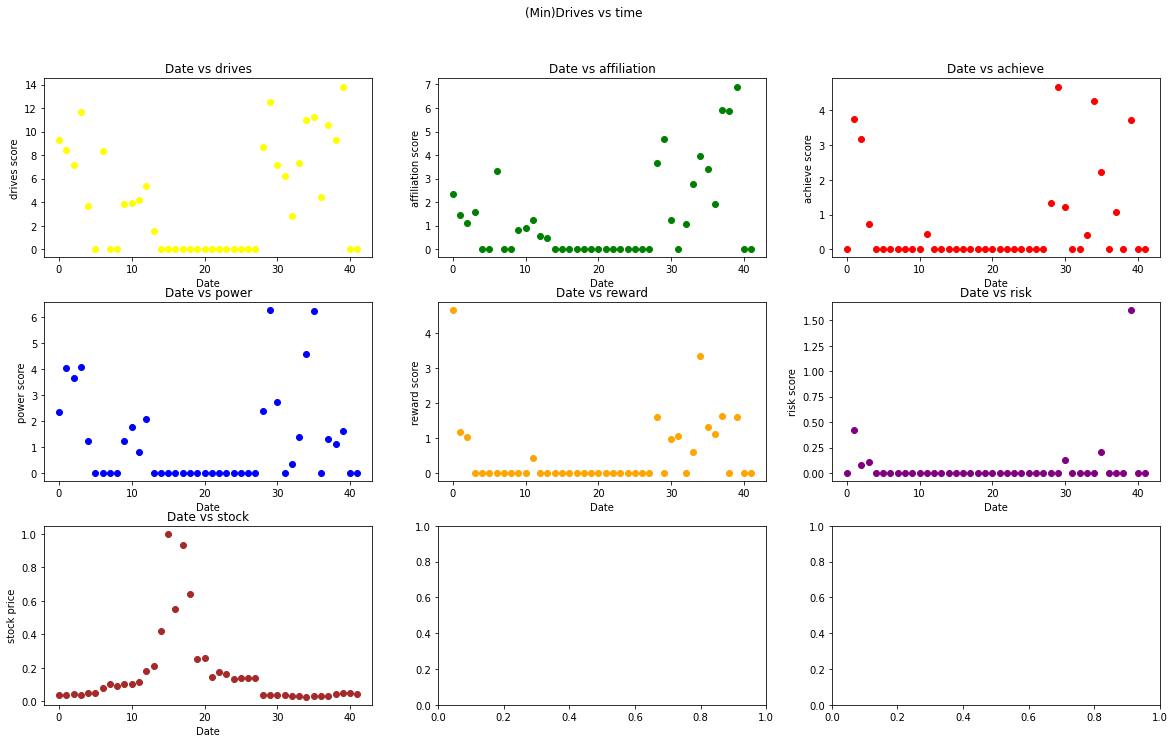

In [26]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(bottom=0.01,hspace=0.25)
fig.suptitle('(Min)Drives vs time')
fig.set_size_inches(20,10)

gm_sort_drives_min = gm_merge_df_min.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_drives_min.shape[0])],gm_sort_drives_min[['drives']],color='yellow',label='drives')
axs[0,0].set_title('Date vs drives')
axs[0,0].set(xlabel='Date', ylabel='drives score')

gm_sort_affiliation_min = gm_merge_df_min.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_affiliation_min.shape[0])],gm_sort_affiliation_min[['affiliation']],color='green',label='affiliation')
axs[0,1].set_title('Date vs affiliation')
axs[0,1].set(xlabel='Date', ylabel='affiliation score')

gm_sort_achieve_min = gm_merge_df_min.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_achieve_min.shape[0])],gm_sort_achieve_min[['achieve']],color='red',label='achieve')
axs[0,2].set_title('Date vs achieve')
axs[0,2].set(xlabel='Date', ylabel='achieve score')

gm_sort_power_min = gm_merge_df_min.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_power_min.shape[0])],gm_sort_power_min[['power']],color='blue',label='power')
axs[1,0].set_title('Date vs power')
axs[1,0].set(xlabel='Date', ylabel='power score')

gm_sort_reward_min = gm_merge_df_min.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_reward_min.shape[0])],gm_sort_reward_min[['reward']],color='orange',label='reward')
axs[1,1].set_title('Date vs reward')
axs[1,1].set(xlabel='Date', ylabel='reward score')

gm_sort_risk_min = gm_merge_df_min.sort_values(by=['Date'])
axs[1,2].scatter([i for i in range(gm_sort_risk_min.shape[0])],gm_sort_risk_min[['risk']],color='purple',label='risk')
axs[1,2].set_title('Date vs risk')
axs[1,2].set(xlabel='Date', ylabel='risk score')

gm_sort_date = gm_merge_df_min.sort_values(by=['Date'])
axs[2,0].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[2,0].set_title('Date vs stock')
axs[2,0].set(xlabel='Date', ylabel='stock price')

plt.show()

# Training with different method

Training with mean drives

In [27]:
#Training models based on the gm data for four features("drives","affiliation","achieve","power","reward","risk") separately
reg_gm_drives_mean = LinearRegression().fit(gm_merge_df_mean[['drives']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_affiliation_mean = LinearRegression().fit(gm_merge_df_mean[['affiliation']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_achieve_mean = LinearRegression().fit(gm_merge_df_mean[['achieve']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_power_mean = LinearRegression().fit(gm_merge_df_mean[['power']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_reward_mean = LinearRegression().fit(gm_merge_df_mean[['reward']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_risk_mean = LinearRegression().fit(gm_merge_df_mean[['risk']][:-10], gm_merge_df_mean[['close']][:-10])

In [28]:
#predict the stock price of gm using new models
pred_gm_drives_mean = reg_gm_drives_mean.predict(gm_merge_df_mean[['drives']][-10:])
pred_gm_affiliation_mean = reg_gm_affiliation_mean.predict(gm_merge_df_mean[['affiliation']][-10:])
pred_gm_achieve_mean = reg_gm_achieve_mean.predict(gm_merge_df_mean[['achieve']][-10:])
pred_gm_power_mean = reg_gm_power_mean.predict(gm_merge_df_mean[['power']][-10:])
pred_gm_reward_mean = reg_gm_reward_mean.predict(gm_merge_df_mean[['reward']][-10:])
pred_gm_risk_mean = reg_gm_risk_mean.predict(gm_merge_df_mean[['risk']][-10:])

#predict on the training model to plot the data
train_gm_drives_mean = reg_gm_drives_mean.predict(gm_merge_df_mean[['drives']][:-10])
train_gm_affiliation_mean = reg_gm_affiliation_mean.predict(gm_merge_df_mean[['affiliation']][:-10])
train_gm_achieve_mean = reg_gm_achieve_mean.predict(gm_merge_df_mean[['achieve']][:-10])
train_gm_power_mean = reg_gm_power_mean.predict(gm_merge_df_mean[['power']][:-10])
train_gm_reward_mean = reg_gm_reward_mean.predict(gm_merge_df_mean[['reward']][:-10])
train_gm_risk_mean = reg_gm_risk_mean.predict(gm_merge_df_mean[['risk']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_mean = pd.concat([gm_merge_df_mean[:-10], pd.DataFrame(train_gm_drives_mean,columns=['pred_drives'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_affiliation_mean,columns=['pred_affiliation'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_achieve_mean,columns=['pred_achieve'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_power_mean,columns=['pred_power'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_reward_mean,columns=['pred_reward'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_risk_mean,columns=['pred_risk'])], axis=1)

#gm_merge_pred1_mean.head

In [29]:
gm_score_drives_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_drives_mean)
gm_score_affiliation_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_affiliation_mean)
gm_score_achieve_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_achieve_mean)
gm_score_power_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_power_mean)
gm_score_reward_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_reward_mean)
gm_score_risk_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_risk_mean)
[gm_score_drives_mean,gm_score_affiliation_mean,gm_score_achieve_mean,gm_score_power_mean,gm_score_reward_mean,gm_score_risk_mean]

[0.03537742446457741,
 0.018914679810760678,
 0.02880422690882961,
 0.051040320603211106,
 0.026128117350015884,
 0.06211825245042304]

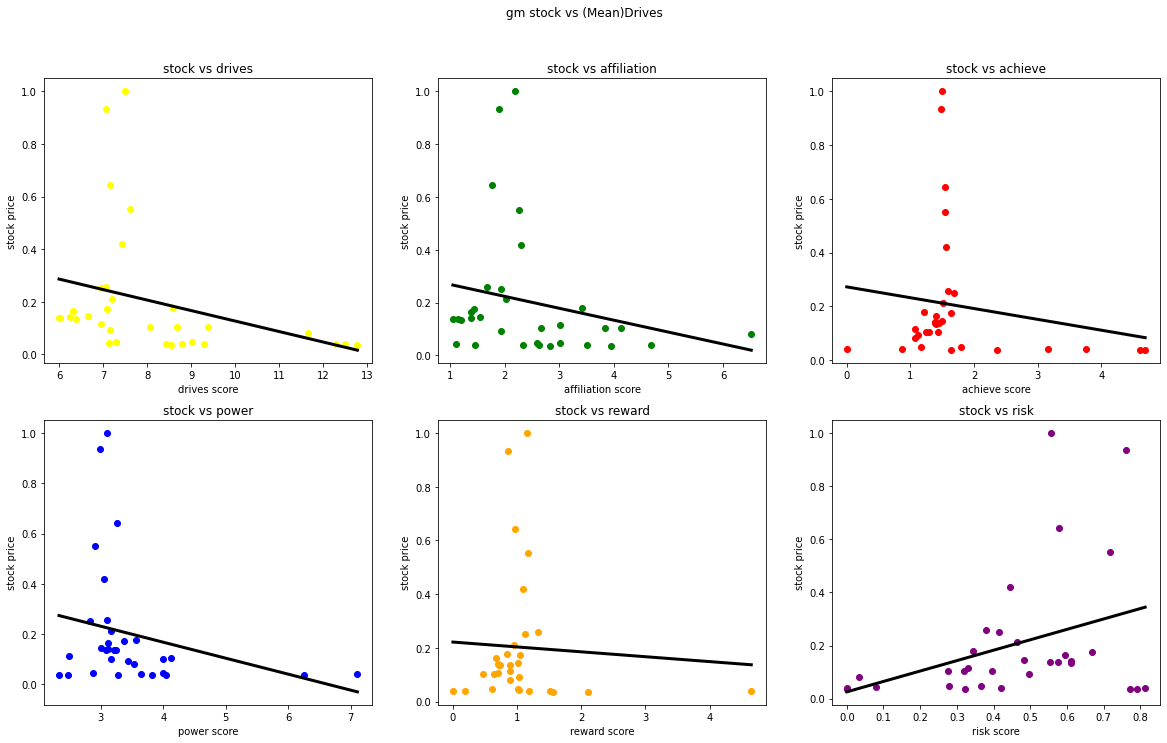

In [30]:
#plot the new gm model ("drives","affiliation","achieve","power","reward","risk")
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Mean)Drives')
fig.set_size_inches(20,10)

gm_sort_drives_mean = gm_merge_pred1_mean.sort_values(by=['drives'])
axs[0,0].scatter(gm_sort_drives_mean[['drives']],gm_sort_drives_mean[['close']],color='yellow',label='drives')#Plotting the data
axs[0,0].plot(gm_sort_drives_mean[['drives']], gm_sort_drives_mean[['pred_drives']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,0].set_title('stock vs drives')
axs[0,0].set(xlabel='drives score', ylabel='stock price')

gm_sort_affiliation_mean = gm_merge_pred1_mean.sort_values(by=['affiliation'])
axs[0,1].scatter(gm_sort_affiliation_mean[['affiliation']],gm_sort_affiliation_mean[['close']],color='green',label='affiliation')#Plotting the data
axs[0,1].plot(gm_sort_affiliation_mean[['affiliation']], gm_sort_affiliation_mean[['pred_affiliation']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs affiliation')
axs[0,1].set(xlabel='affiliation score', ylabel='stock price')

gm_sort_achieve_mean = gm_merge_pred1_mean.sort_values(by=['achieve'])
axs[0,2].scatter(gm_sort_achieve_mean[['achieve']],gm_sort_achieve_mean[['close']],color='red',label='achieve') #Plotting the data
axs[0,2].plot(gm_sort_achieve_mean[['achieve']], gm_sort_achieve_mean[['pred_achieve']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,2].set_title('stock vs achieve')
axs[0,2].set(xlabel='achieve score', ylabel='stock price')

gm_sort_power_mean = gm_merge_pred1_mean.sort_values(by=['power'])
axs[1,0].scatter(gm_sort_power_mean[['power']],gm_sort_power_mean[['close']],color='blue',label='power')#Plotting the data
axs[1,0].plot(gm_sort_power_mean[['power']], gm_sort_power_mean[['pred_power']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs power')
axs[1,0].set(xlabel='power score', ylabel='stock price')

gm_sort_reward_mean = gm_merge_pred1_mean.sort_values(by=['reward'])
axs[1,1].scatter(gm_sort_reward_mean[['reward']],gm_sort_reward_mean[['close']],color='orange',label='reward')#Plotting the data
axs[1,1].plot(gm_sort_reward_mean[['reward']], gm_sort_reward_mean[['pred_reward']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs reward')
axs[1,1].set(xlabel='reward score', ylabel='stock price')

gm_sort_risk_mean = gm_merge_pred1_mean.sort_values(by=['risk'])
axs[1,2].scatter(gm_sort_risk_mean[['risk']],gm_sort_risk_mean[['close']],color='purple',label='risk')#Plotting the data
axs[1,2].plot(gm_sort_risk_mean[['risk']], gm_sort_risk_mean[['pred_risk']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,2].set_title('stock vs risk')
axs[1,2].set(xlabel='risk score', ylabel='stock price')

plt.show()

Training with median drives

In [31]:
#Training models based on the gm data for four features("drives","affiliation","achieve","power","reward","risk") separately
reg_gm_drives_median = LinearRegression().fit(gm_merge_df_median[['drives']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_affiliation_median = LinearRegression().fit(gm_merge_df_median[['affiliation']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_achieve_median = LinearRegression().fit(gm_merge_df_median[['achieve']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_power_median = LinearRegression().fit(gm_merge_df_median[['power']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_reward_median = LinearRegression().fit(gm_merge_df_median[['reward']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_risk_median = LinearRegression().fit(gm_merge_df_median[['risk']][:-10], gm_merge_df_median[['close']][:-10])

In [32]:
#predict the stock price of gm using new models
pred_gm_drives_median = reg_gm_drives_median.predict(gm_merge_df_median[['drives']][-10:])
pred_gm_affiliation_median = reg_gm_affiliation_median.predict(gm_merge_df_median[['affiliation']][-10:])
pred_gm_achieve_median = reg_gm_achieve_median.predict(gm_merge_df_median[['achieve']][-10:])
pred_gm_power_median = reg_gm_power_median.predict(gm_merge_df_median[['power']][-10:])
pred_gm_reward_median = reg_gm_reward_median.predict(gm_merge_df_median[['reward']][-10:])
pred_gm_risk_median = reg_gm_risk_median.predict(gm_merge_df_median[['risk']][-10:])

#predict on the training model to plot the data
train_gm_drives_median = reg_gm_drives_median.predict(gm_merge_df_median[['drives']][:-10])
train_gm_affiliation_median = reg_gm_affiliation_median.predict(gm_merge_df_median[['affiliation']][:-10])
train_gm_achieve_median = reg_gm_achieve_median.predict(gm_merge_df_median[['achieve']][:-10])
train_gm_power_median = reg_gm_power_median.predict(gm_merge_df_median[['power']][:-10])
train_gm_reward_median = reg_gm_reward_median.predict(gm_merge_df_median[['reward']][:-10])
train_gm_risk_median = reg_gm_risk_median.predict(gm_merge_df_median[['risk']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_median = pd.concat([gm_merge_df_median[:-10], pd.DataFrame(train_gm_drives_median,columns=['pred_drives'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_affiliation_median,columns=['pred_affiliation'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_achieve_median,columns=['pred_achieve'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_power_median,columns=['pred_power'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_reward_median,columns=['pred_reward'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_risk_median,columns=['pred_risk'])], axis=1)

#gm_merge_pred1_median

In [33]:
gm_score_drives_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_drives_median)
gm_score_affiliation_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_affiliation_median)
gm_score_achieve_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_achieve_median)
gm_score_power_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_power_median)
gm_score_reward_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_reward_median)
gm_score_risk_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_risk_median)
[gm_score_drives_median,gm_score_affiliation_median,gm_score_achieve_median,gm_score_power_median,gm_score_reward_median,gm_score_risk_median]

[0.031922806756016164,
 0.015598954977097923,
 0.02869227558000017,
 0.04365905544424263,
 0.026688179807922863,
 0.06570512741267426]

In [ ]:
#plot the new gm model

Training with std drives

In [34]:
#Training models based on the gm data for four features("drives","affiliation","achieve","power","reward","risk") separately
reg_gm_drives_std = LinearRegression().fit(gm_merge_df_std[['drives']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_affiliation_std = LinearRegression().fit(gm_merge_df_std[['affiliation']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_achieve_std = LinearRegression().fit(gm_merge_df_std[['achieve']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_power_std = LinearRegression().fit(gm_merge_df_std[['power']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_reward_std = LinearRegression().fit(gm_merge_df_std[['reward']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_risk_std = LinearRegression().fit(gm_merge_df_std[['risk']][:-10], gm_merge_df_std[['close']][:-10])

In [35]:
#predict the stock price of gm using new models
pred_gm_drives_std = reg_gm_drives_std.predict(gm_merge_df_std[['drives']][-10:])
pred_gm_affiliation_std = reg_gm_affiliation_std.predict(gm_merge_df_std[['affiliation']][-10:])
pred_gm_achieve_std = reg_gm_achieve_std.predict(gm_merge_df_std[['achieve']][-10:])
pred_gm_power_std = reg_gm_power_std.predict(gm_merge_df_std[['power']][-10:])
pred_gm_reward_std = reg_gm_reward_std.predict(gm_merge_df_std[['reward']][-10:])
pred_gm_risk_std = reg_gm_risk_std.predict(gm_merge_df_std[['risk']][-10:])

#predict on the training model to plot the data
train_gm_drives_std = reg_gm_drives_std.predict(gm_merge_df_std[['drives']][:-10])
train_gm_affiliation_std = reg_gm_affiliation_std.predict(gm_merge_df_std[['affiliation']][:-10])
train_gm_achieve_std = reg_gm_achieve_std.predict(gm_merge_df_std[['achieve']][:-10])
train_gm_power_std = reg_gm_power_std.predict(gm_merge_df_std[['power']][:-10])
train_gm_reward_std = reg_gm_reward_std.predict(gm_merge_df_std[['reward']][:-10])
train_gm_risk_std = reg_gm_risk_std.predict(gm_merge_df_std[['risk']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_std = pd.concat([gm_merge_df_std[:-10], pd.DataFrame(train_gm_drives_std,columns=['pred_drives'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_affiliation_std,columns=['pred_affiliation'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_achieve_std,columns=['pred_achieve'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_power_std,columns=['pred_power'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_reward_std,columns=['pred_reward'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_risk_std,columns=['pred_risk'])], axis=1)

#gm_merge_pred1_std

In [36]:
gm_score_drives_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_drives_std)
gm_score_affiliation_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_affiliation_std)
gm_score_achieve_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_achieve_std)
gm_score_power_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_power_std)
gm_score_reward_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_reward_std)
gm_score_risk_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_risk_std)
[gm_score_drives_std,gm_score_affiliation_std,gm_score_achieve_std,gm_score_power_std,gm_score_reward_std,gm_score_risk_std]

[0.05000519453750361,
 0.05691240813308514,
 0.04615649563418387,
 0.10610124601491862,
 0.03728609420747643,
 0.10681538411662994]

In [ ]:
#plot the new gm model

Training with max drives

In [37]:
#Training models based on the gm data for four features("drives","affiliation","achieve","power","reward","risk") separately
reg_gm_drives_max = LinearRegression().fit(gm_merge_df_max[['drives']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_affiliation_max = LinearRegression().fit(gm_merge_df_max[['affiliation']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_achieve_max = LinearRegression().fit(gm_merge_df_max[['achieve']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_power_max = LinearRegression().fit(gm_merge_df_max[['power']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_reward_max = LinearRegression().fit(gm_merge_df_max[['reward']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_risk_max = LinearRegression().fit(gm_merge_df_max[['risk']][:-10], gm_merge_df_max[['close']][:-10])

In [38]:
#predict the stock price of gm using new models
pred_gm_drives_max = reg_gm_drives_max.predict(gm_merge_df_max[['drives']][-10:])
pred_gm_affiliation_max = reg_gm_affiliation_max.predict(gm_merge_df_max[['affiliation']][-10:])
pred_gm_achieve_max = reg_gm_achieve_max.predict(gm_merge_df_max[['achieve']][-10:])
pred_gm_power_max = reg_gm_power_max.predict(gm_merge_df_max[['power']][-10:])
pred_gm_reward_max = reg_gm_reward_max.predict(gm_merge_df_max[['reward']][-10:])
pred_gm_risk_max = reg_gm_risk_max.predict(gm_merge_df_max[['risk']][-10:])

#predict on the training model to plot the data
train_gm_drives_max = reg_gm_drives_max.predict(gm_merge_df_max[['drives']][:-10])
train_gm_affiliation_max = reg_gm_affiliation_max.predict(gm_merge_df_max[['affiliation']][:-10])
train_gm_achieve_max = reg_gm_achieve_max.predict(gm_merge_df_max[['achieve']][:-10])
train_gm_power_max = reg_gm_power_max.predict(gm_merge_df_max[['power']][:-10])
train_gm_reward_max = reg_gm_reward_max.predict(gm_merge_df_max[['reward']][:-10])
train_gm_risk_max = reg_gm_risk_max.predict(gm_merge_df_max[['risk']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_max = pd.concat([gm_merge_df_max[:-10], pd.DataFrame(train_gm_drives_max,columns=['pred_drives'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_affiliation_max,columns=['pred_affiliation'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_achieve_max,columns=['pred_achieve'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_power_max,columns=['pred_power'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_reward_max,columns=['pred_reward'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_risk_max,columns=['pred_risk'])], axis=1)

#gm_merge_pred1_max

In [39]:
gm_score_drives_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_drives_max)
gm_score_affiliation_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_affiliation_max)
gm_score_achieve_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_achieve_max)
gm_score_power_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_power_max)
gm_score_reward_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_reward_max)
gm_score_risk_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_risk_max)
[gm_score_drives_max,gm_score_affiliation_max,gm_score_achieve_max,gm_score_power_max,gm_score_reward_max,gm_score_risk_max]

[0.0204098335063499,
 0.02012818674433608,
 0.022644745949482025,
 0.02411491085769231,
 0.012088020242611998,
 0.013228180427487074]

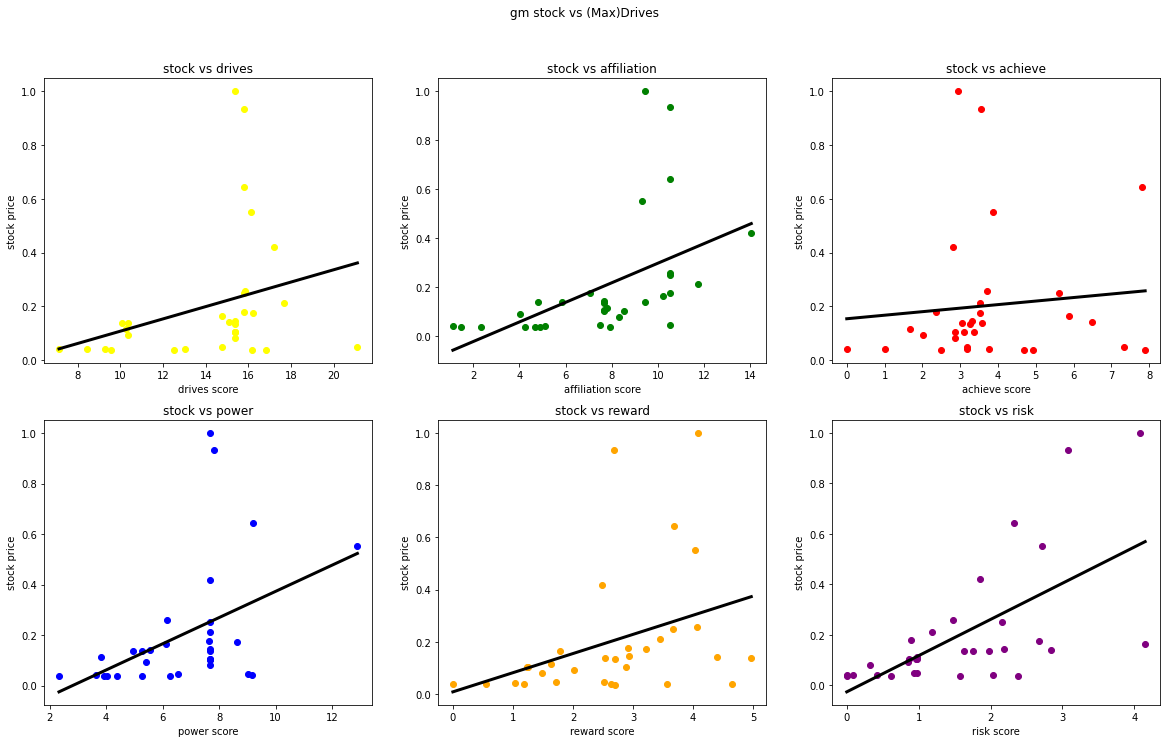

In [40]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Max)Drives')
fig.set_size_inches(20,10)

gm_sort_drives_max = gm_merge_pred1_max.sort_values(by=['drives'])
axs[0,0].scatter(gm_sort_drives_max[['drives']],gm_sort_drives_max[['close']],color='yellow',label='drives')#Plotting the data
axs[0,0].plot(gm_sort_drives_max[['drives']], gm_sort_drives_max[['pred_drives']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,0].set_title('stock vs drives')
axs[0,0].set(xlabel='drives score', ylabel='stock price')

gm_sort_affiliation_max = gm_merge_pred1_max.sort_values(by=['affiliation'])
axs[0,1].scatter(gm_sort_affiliation_max[['affiliation']],gm_sort_affiliation_max[['close']],color='green',label='affiliation')#Plotting the data
axs[0,1].plot(gm_sort_affiliation_max[['affiliation']], gm_sort_affiliation_max[['pred_affiliation']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs affiliation')
axs[0,1].set(xlabel='affiliation score', ylabel='stock price')

gm_sort_achieve_max = gm_merge_pred1_max.sort_values(by=['achieve'])
axs[0,2].scatter(gm_sort_achieve_max[['achieve']],gm_sort_achieve_max[['close']],color='red',label='achieve') #Plotting the data
axs[0,2].plot(gm_sort_achieve_max[['achieve']], gm_sort_achieve_max[['pred_achieve']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,2].set_title('stock vs achieve')
axs[0,2].set(xlabel='achieve score', ylabel='stock price')

gm_sort_power_max = gm_merge_pred1_max.sort_values(by=['power'])
axs[1,0].scatter(gm_sort_power_max[['power']],gm_sort_power_max[['close']],color='blue',label='power')#Plotting the data
axs[1,0].plot(gm_sort_power_max[['power']], gm_sort_power_max[['pred_power']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs power')
axs[1,0].set(xlabel='power score', ylabel='stock price')

gm_sort_reward_max = gm_merge_pred1_max.sort_values(by=['reward'])
axs[1,1].scatter(gm_sort_reward_max[['reward']],gm_sort_reward_max[['close']],color='orange',label='reward')#Plotting the data
axs[1,1].plot(gm_sort_reward_max[['reward']], gm_sort_reward_max[['pred_reward']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs reward')
axs[1,1].set(xlabel='reward score', ylabel='stock price')

gm_sort_risk_max = gm_merge_pred1_max.sort_values(by=['risk'])
axs[1,2].scatter(gm_sort_risk_max[['risk']],gm_sort_risk_max[['close']],color='purple',label='risk')#Plotting the data
axs[1,2].plot(gm_sort_risk_max[['risk']], gm_sort_risk_max[['pred_risk']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,2].set_title('stock vs risk')
axs[1,2].set(xlabel='risk score', ylabel='stock price')

plt.show()

Training with min drives

In [41]:
#Training models based on the gm data for four features("drives","affiliation","achieve","power","reward","risk") separately
reg_gm_drives_min = LinearRegression().fit(gm_merge_df_min[['drives']][:-10], gm_merge_df_min[['close']][:-10])
reg_gm_affiliation_min = LinearRegression().fit(gm_merge_df_min[['affiliation']][:-10], gm_merge_df_min[['close']][:-10])
reg_gm_achieve_min = LinearRegression().fit(gm_merge_df_min[['achieve']][:-10], gm_merge_df_min[['close']][:-10])
reg_gm_power_min = LinearRegression().fit(gm_merge_df_min[['power']][:-10], gm_merge_df_min[['close']][:-10])
reg_gm_reward_min = LinearRegression().fit(gm_merge_df_min[['reward']][:-10], gm_merge_df_min[['close']][:-10])
reg_gm_risk_min = LinearRegression().fit(gm_merge_df_min[['risk']][:-10], gm_merge_df_min[['close']][:-10])

In [42]:
#predict the stock price of gm using new models
pred_gm_drives_min = reg_gm_drives_min.predict(gm_merge_df_min[['drives']][-10:])
pred_gm_affiliation_min = reg_gm_affiliation_min.predict(gm_merge_df_min[['affiliation']][-10:])
pred_gm_achieve_min = reg_gm_achieve_min.predict(gm_merge_df_min[['achieve']][-10:])
pred_gm_power_min = reg_gm_power_min.predict(gm_merge_df_min[['power']][-10:])
pred_gm_reward_min = reg_gm_reward_min.predict(gm_merge_df_min[['reward']][-10:])
pred_gm_risk_min = reg_gm_risk_min.predict(gm_merge_df_min[['risk']][-10:])

#predict on the training model to plot the data
train_gm_drives_min = reg_gm_drives_min.predict(gm_merge_df_min[['drives']][:-10])
train_gm_affiliation_min = reg_gm_affiliation_min.predict(gm_merge_df_min[['affiliation']][:-10])
train_gm_achieve_min = reg_gm_achieve_min.predict(gm_merge_df_min[['achieve']][:-10])
train_gm_power_min = reg_gm_power_min.predict(gm_merge_df_min[['power']][:-10])
train_gm_reward_min = reg_gm_reward_min.predict(gm_merge_df_min[['reward']][:-10])
train_gm_risk_min = reg_gm_risk_min.predict(gm_merge_df_min[['risk']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_min = pd.concat([gm_merge_df_min[:-10], pd.DataFrame(train_gm_drives_min,columns=['pred_drives'])], axis=1)
gm_merge_pred1_min = pd.concat([gm_merge_pred1_min, pd.DataFrame(train_gm_affiliation_min,columns=['pred_affiliation'])], axis=1)
gm_merge_pred1_min = pd.concat([gm_merge_pred1_min, pd.DataFrame(train_gm_achieve_min,columns=['pred_achieve'])], axis=1)
gm_merge_pred1_min = pd.concat([gm_merge_pred1_min, pd.DataFrame(train_gm_power_min,columns=['pred_power'])], axis=1)
gm_merge_pred1_min = pd.concat([gm_merge_pred1_min, pd.DataFrame(train_gm_reward_min,columns=['pred_reward'])], axis=1)
gm_merge_pred1_min = pd.concat([gm_merge_pred1_min, pd.DataFrame(train_gm_risk_min,columns=['pred_risk'])], axis=1)

#gm_merge_pred1_min

In [43]:
gm_score_drives_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_drives_min)
gm_score_affiliation_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_affiliation_min)
gm_score_achieve_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_achieve_min)
gm_score_power_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_power_min)
gm_score_reward_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_reward_min)
gm_score_risk_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_risk_min)
[gm_score_drives_min,gm_score_affiliation_min,gm_score_achieve_min,gm_score_power_min,gm_score_reward_min,gm_score_risk_min]

[0.02097792999662132,
 0.030011482174679544,
 0.023834033713208025,
 0.029224225309612793,
 0.01956768802743281,
 0.0944511922155536]

In [ ]:
#plot the new gm model